In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

import src.data_processing as dp
import src.feature_engineering as fe
import src.feature_processor as fp
import src.model as model
import src.utils as utils

In [2]:
# Load data
train_path = '../data/train.xlsx'
test_path = '../data/test.xlsx'

train_data_raw, test_data_raw = pd.read_excel(train_path), pd.read_excel(test_path)

In [3]:
# Split training data for validation
train_data, val_data = train_test_split(
    train_data_raw, 
    test_size=0.2, 
    random_state=42
)

feature_processor = fp.FeatureProcessor()


# Fit and transform training data
train_processed = feature_processor.fit_transform(train_data)

# Transform validation and test data using training statistics
val_processed = feature_processor.transform(val_data)
test_processed = feature_processor.transform(test_data_raw)

In [ ]:
# Prepare data for model
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price', 'number_of_competitors'], axis=1)
y_train = train_processed['competitor_lowest_price']

X_val = val_processed.drop(['quote_id', 'competitor_lowest_price', 'number_of_competitors'], axis=1)
y_val = val_processed['competitor_lowest_price']

Performing PCA analysis...


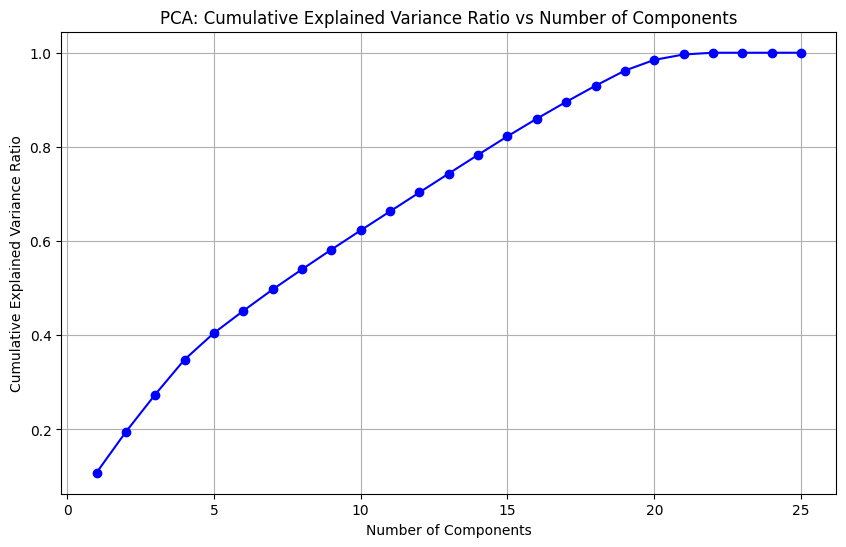


PCA Explained Variance Ratio for first 3 components:
Component 1: 0.1081 (10.81%)
Component 2: 0.0867 (8.67%)
Component 3: 0.0794 (7.94%)


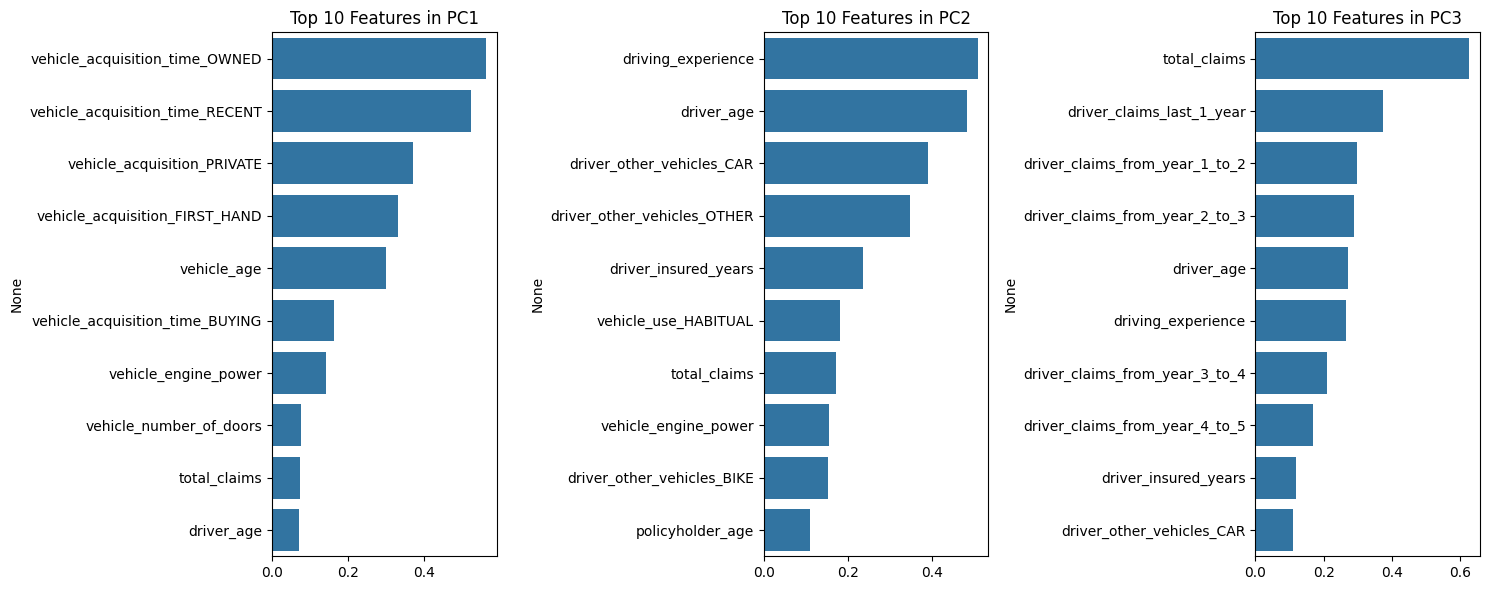

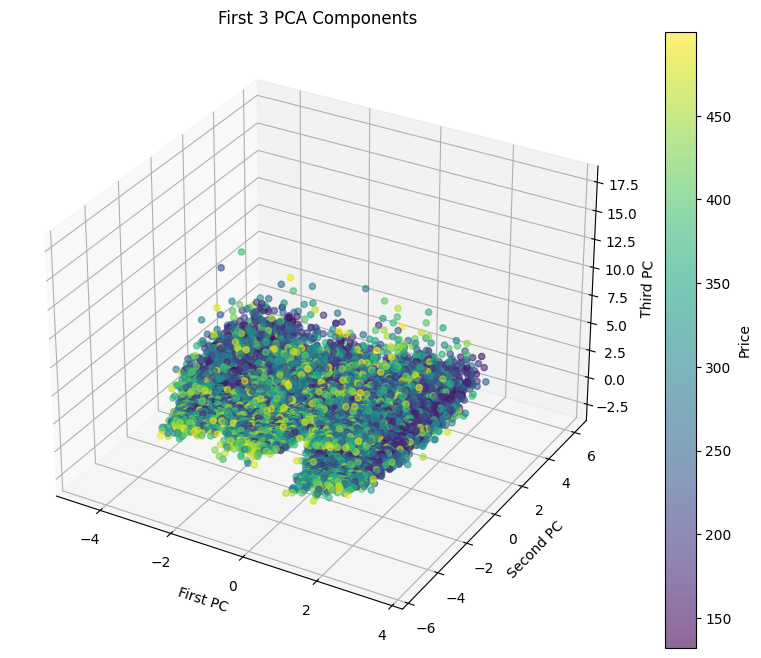


Performing t-SNE analysis...


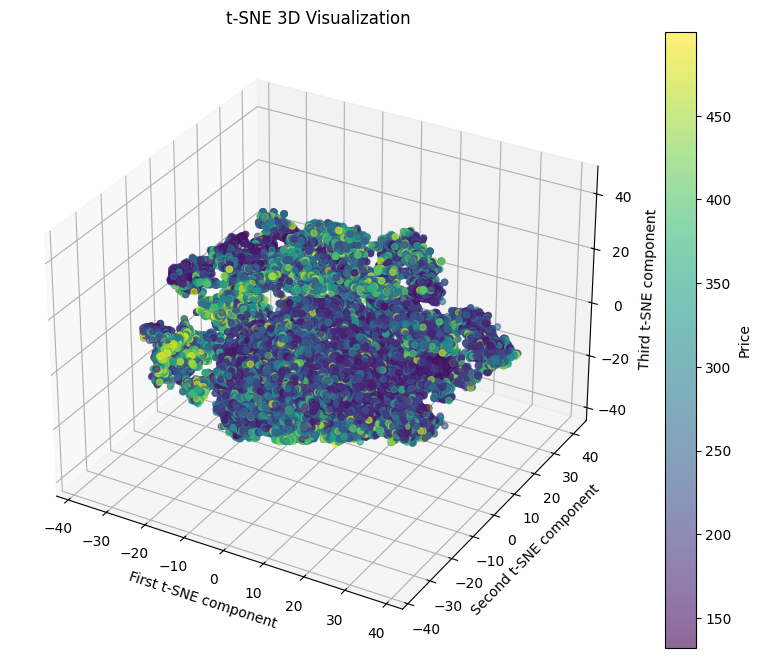

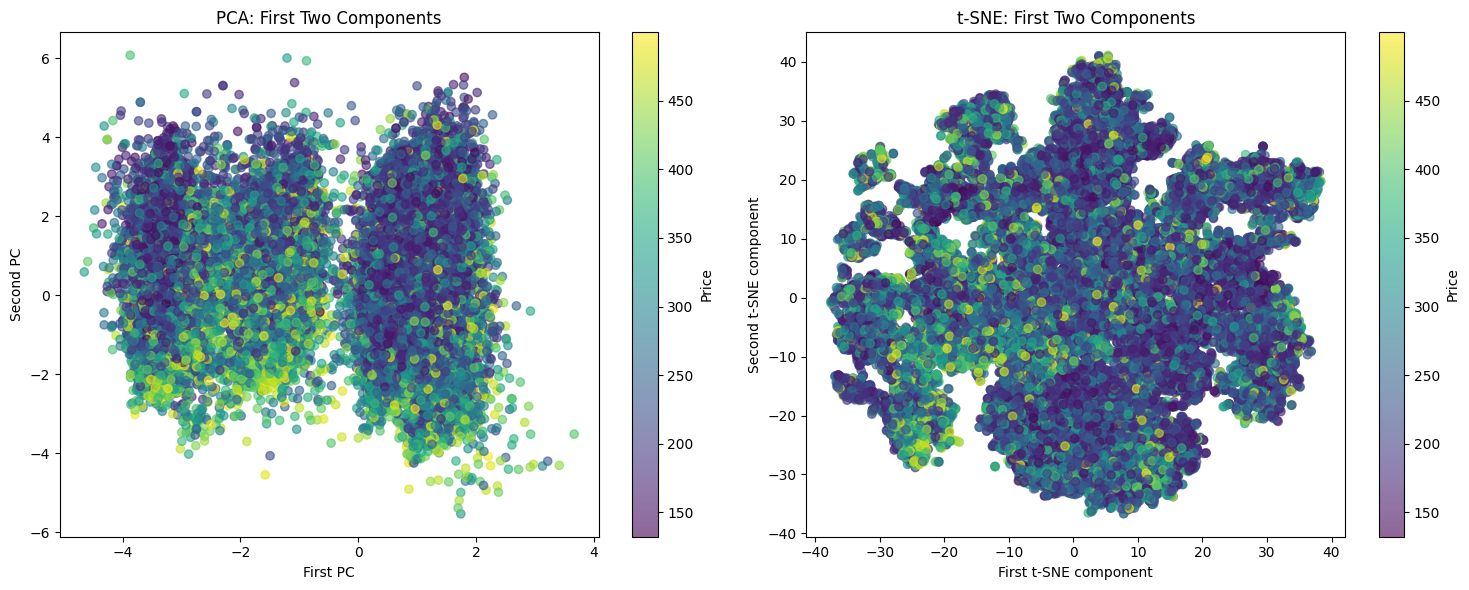

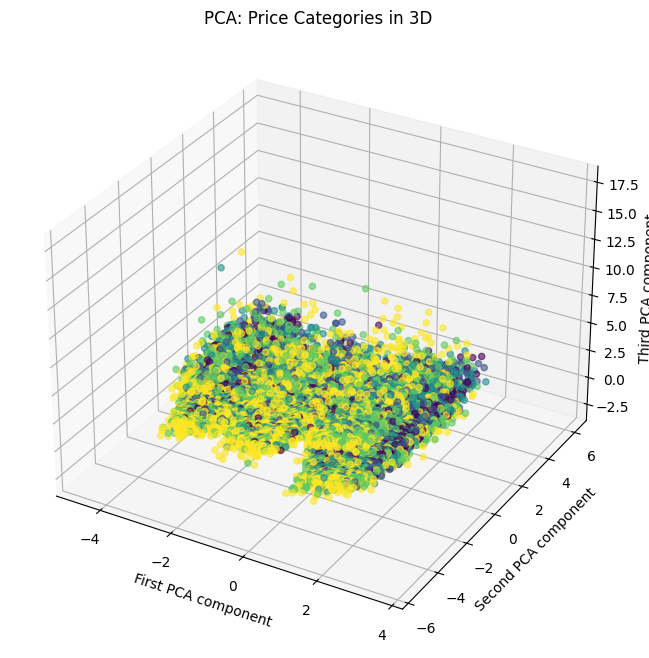

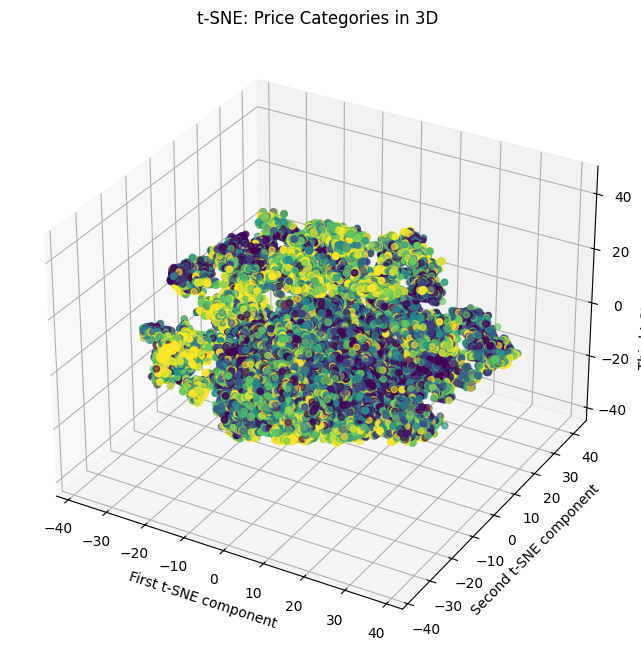


Summary statistics for PCA components by price category:
                   PCA1                                                    \
                  count      mean       std       min       25%       50%   
Price_Category                                                              
Very Low        10033.0  0.270343  1.514031 -4.351047  0.442324  0.763323   
Low             10034.0  0.211526  1.518400 -4.263522  0.366614  0.775334   
Medium          10029.0  0.092887  1.600911 -4.212810  0.081809  0.746432   
High            10031.0 -0.118205  1.701492 -4.475645 -1.405544  0.662769   
Very High       10032.0 -0.456604  1.763929 -4.652748 -1.829733  0.400449   

                                       PCA2            ...            \
                     75%       max    count      mean  ...       75%   
Price_Category                                         ...             
Very Low        1.135666  2.330297  10033.0  0.400579  ...  1.319731   
Low             1.126141  2.372574  1

/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_66706/1317886711.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(reduced_dims.groupby('Price_Category')[['PCA1', 'PCA2', 'PCA3']].describe())


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from src.feature_processor import FeatureProcessor

# Load and preprocess data
feature_processor = FeatureProcessor()
train_processed = feature_processor.fit_transform(train_data)
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price', 'number_of_competitors'], axis=1)
y_train = train_processed['competitor_lowest_price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# PCA Analysis
print("Performing PCA analysis...")

# Initialize and fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.show()

# Print explained variance for first 3 components
print("\nPCA Explained Variance Ratio for first 3 components:")
for i, var in enumerate(explained_variance_ratio[:3], 1):
    print(f"Component {i}: {var:.4f} ({var*100:.2f}%)")

# Get feature importance in PCA
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=X_train.columns
)

# Plot top 10 features for first 3 PCs
plt.figure(figsize=(15, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    pc_importance = feature_importance[f'PC{i+1}'].abs().sort_values(ascending=False)[:10]
    sns.barplot(x=pc_importance.values, y=pc_importance.index)
    plt.title(f'Top 10 Features in PC{i+1}')
plt.tight_layout()
plt.show()

# 3D scatter plot of first 3 PCA components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Price')
ax.set_xlabel('First PC')
ax.set_ylabel('Second PC')
ax.set_zlabel('Third PC')
plt.title('First 3 PCA Components')
plt.show()

# t-SNE Analysis
print("\nPerforming t-SNE analysis...")

# Initialize and fit t-SNE
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

# 3D scatter plot of t-SNE components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], 
                    c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Price')
ax.set_xlabel('First t-SNE component')
ax.set_ylabel('Second t-SNE component')
ax.set_zlabel('Third t-SNE component')
plt.title('t-SNE 3D Visualization')
plt.show()

# Compare PCA and t-SNE 2D projections
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PCA 2D
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
ax1.set_xlabel('First PC')
ax1.set_ylabel('Second PC')
ax1.set_title('PCA: First Two Components')
plt.colorbar(scatter1, ax=ax1, label='Price')

# t-SNE 2D
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
ax2.set_xlabel('First t-SNE component')
ax2.set_ylabel('Second t-SNE component')
ax2.set_title('t-SNE: First Two Components')
plt.colorbar(scatter2, ax=ax2, label='Price')

plt.tight_layout()
plt.show()


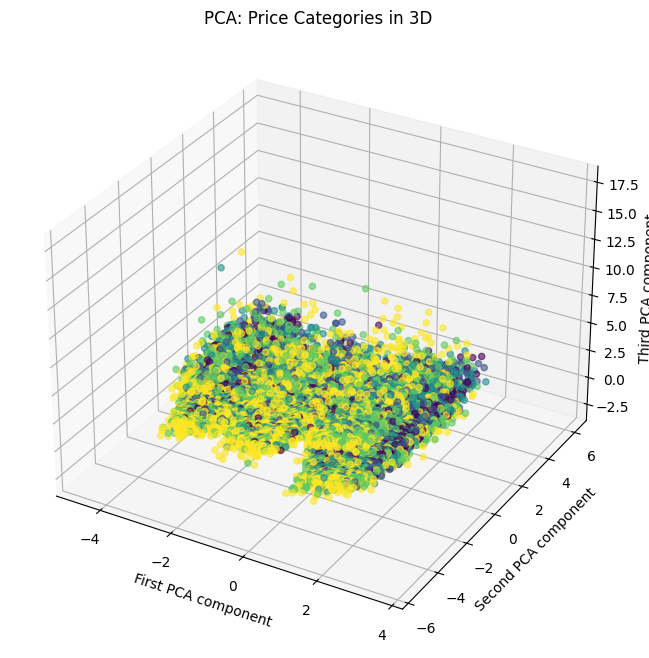

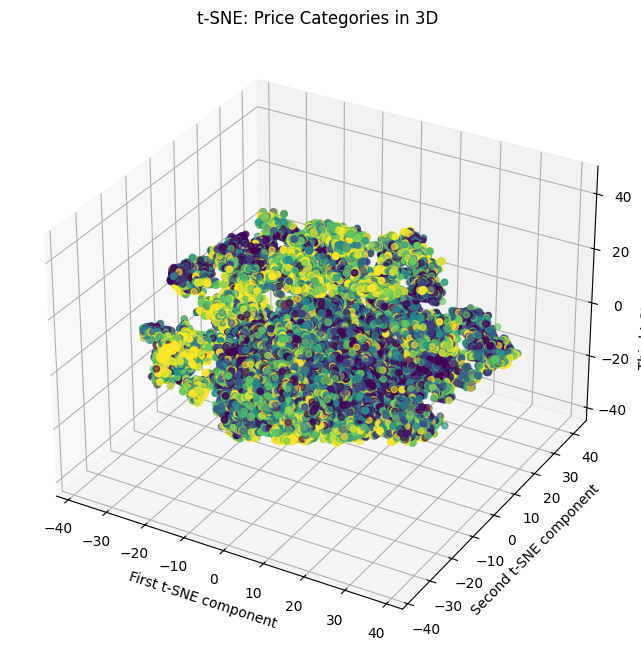


Summary statistics for PCA components by price category:
                   PCA1                                                    \
                  count      mean       std       min       25%       50%   
Price_Category                                                              
Very Low        10033.0  0.270343  1.514031 -4.351047  0.442324  0.763323   
Low             10034.0  0.211526  1.518400 -4.263522  0.366614  0.775334   
Medium          10029.0  0.092887  1.600911 -4.212810  0.081809  0.746432   
High            10031.0 -0.118205  1.701492 -4.475645 -1.405544  0.662769   
Very High       10032.0 -0.456604  1.763929 -4.652748 -1.829733  0.400449   

                                       PCA2            ...            \
                     75%       max    count      mean  ...       75%   
Price_Category                                         ...             
Very Low        1.135666  2.330297  10033.0  0.400579  ...  1.319731   
Low             1.126141  2.372574  1

/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_66706/1546013155.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(reduced_dims.groupby('Price_Category')[['PCA1', 'PCA2', 'PCA3']].describe())
/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_66706/1546013155.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(reduced_dims.groupby('Price_Category')[['TSNE1', 'TSNE2', 'TSNE3']].describe())


In [7]:


# Analysis of clusters in reduced dimensions
# Create price bins for analysis
price_bins = pd.qcut(y_train, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Function to plot reduced dimensions with price categories
def plot_reduced_dims(X_reduced, method_name):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                        c=pd.Categorical(price_bins).codes, 
                        cmap='viridis', alpha=0.6)
    ax.set_xlabel(f'First {method_name} component')
    ax.set_ylabel(f'Second {method_name} component')
    ax.set_zlabel(f'Third {method_name} component')
    plt.title(f'{method_name}: Price Categories in 3D')
    plt.show()

# Plot both PCA and t-SNE with price categories
plot_reduced_dims(X_pca[:, :3], 'PCA')
plot_reduced_dims(X_tsne, 't-SNE')

# Save the reduced dimensions for further analysis
reduced_dims = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'PCA3': X_pca[:, 2],
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'TSNE3': X_tsne[:, 2],
    'Price': y_train,
    'Price_Category': price_bins
})

# Print summary statistics for each component by price category
print("\nSummary statistics for PCA components by price category:")
print(reduced_dims.groupby('Price_Category')[['PCA1', 'PCA2', 'PCA3']].describe())

print("Summary statistics for t-SNE components by price category:")
print(reduced_dims.groupby('Price_Category')[['TSNE1', 'TSNE2', 'TSNE3']].describe())
